<a href="https://colab.research.google.com/github/Ramprabu95/AI_based_image_compression/blob/main/image_compression_ml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Learning Convolutional Networks for Content-weighted Image Compression


In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn.functional as F

**Layers of the Autoencoder**

Components in the ML model are encoder, decoder and importance map generator. All these components are convolutional neural network models.

Layers in the Encoder : 

1. Convolution Layer of 128 filters size 8 and stride 4
2. One Residual Block
3. Convolutional Layer of 256 filters size 4 and stride 2
4. Two Residual blocks (output of this layer is the intermediate feature maps)
5. Convolution Layer of 256 filters and size 1.
6. Sigmoid function at the end and relu functions between each layer
7. Binarizing function

In [2]:
#GPU device definition
device = torch.device('cuda')

# Definition of convolution layer
def conv(ni, nf, kernal_size=3, stride=1, padding=1, **kwargs):
    _conv = nn.Conv2d(ni, nf, kernel_size=kernal_size,stride=stride,padding=padding, **kwargs)
    nn.init.kaiming_normal_(_conv.weight)
    nn.init.zeros_(_conv.bias)
    return _conv

# Definition of a residual block
class ResBlock(nn.Module):
  def __init__(self, ni, nh=128):
    super(ResBlock,self).__init__()
    self.conv1 = conv(ni, nh)
    self.conv2 = conv(nh, ni)
  def forward(self, x):
    return x  + self.conv2(F.relu(self.conv1(x)))

# Definition of Relu block
relu = nn.ReLU()

# Definition of encoder till intermediate map layer
class Encoder(nn.Module):
  def __init__(self):
    super(Encoder, self).__init__()
    self.conv1 = conv(3,128,8,4,2) # first convolution layer
    self.res_block1 = ResBlock(128) # first residual block layer
    self.conv2 = conv(128,256,4,2,1) # second convolution layer
    self.res_block2 = ResBlock(256) # 2 residual blocks following the 2nd conv layer
    self.res_block3 = ResBlock(256)

  def forward(self,x):
    x = F.relu(self.conv1(x))
    x = F.relu(self.res_block1(x))
    x = F.relu(self.conv2(x))
    x = F.relu(self.res_block3(self.res_block2(x)))
    return(x)

# Function that does the binarizing action
class Binarizing_function(torch.autograd.Function):
  @staticmethod
  def forward(ctx, i):
    i = (i>0.5).float()
    return i
  
  @staticmethod
  def backward(ctx,grad_output):
    return grad_output

def binary_value(x):
  return Binarizing_function.apply(x)

class Bin(nn.Module):
  def __init__(self,func):
    super(Bin,self).__init__()
    self.func = func

  def forward(self,x):
    return self.func(x)


Importance Map Generator : This layer takes the the intermediate feature map as input and gives the a masked importance map as output

The Layers in importance map generator : 
1. Three convolutional layers with relu layers in between
2. Quantizer
3. Mask Generator

In [3]:
# Encoder class definition
# If return_imp_map is true then the importance map is returned
#Else the compressed codec of the image is returned

class Encoder_full(nn.Module):
  def __init__(self,return_imp_map = False):
    super(Encoder_full,self).__init__()
    # Layers of the encoder
    self.sig = nn.Sigmoid() #Sigmoid function
    self.conv3 = conv(256,256,3,1,1) 
    self.sig1 = nn.Sigmoid()
    
    # Layers of the importance map generator
    self.conv4 = conv(256,256)
    self.conv5 = conv(256,256)
    self.conv6 = conv(256,1)

  def forward(self,x,return_imp_map = False):
    if return_imp_map == True:
      # generation of the importance map
      x = self.sig1(self.conv6(F.relu(self.conv5(F.relu(self.conv4(x))))))
      return x
    else:
      # generation of the compressed image codec
      x = self.sig1(self.conv3(x))
      return x
   

# Quantizer of the importance map

class Quantizing(torch.autograd.Function):
  @staticmethod
  def forward(ctx, i):
    p_shape = i.shape
    p = i.clone().to(device)
    p = torch.reshape(p,(-1,)).to(device)
    L = 64
    for l in range(1,L):
      count = 0
      for q in p:
        if((q<l/L) and (q>=(l-1)/L)):
          p[count] = l-1
        count = count +1
    p = torch.reshape(p,p_shape).to(device)
    return p

  @staticmethod
  def backward(ctx, grad_output):
    return grad_output

#funtion that applies the quantizing function
def quantize_values(x):
  return Quantizing.apply(x)

#Masking function of the quantized importance map
class Masking(torch.autograd.Function):
  @staticmethod
  def forward(ctx,i):
    N,_,H,W = i.shape
    #print(i.shape)
    n = 256 # as per the paper
    L = 64 # as per the paper
    mask = torch.zeros(n,N*H*W).to(device)
    q_important = i
    q_important_flat = q_important.view(1, N*H*W)
    #print(q_important_flat.shape, q_important.shape)
    for index in range(n):
      count = 0
      for q in q_important_flat:
        mask[index,:] = torch.where(index <= (n/L)*q_important_flat[count],torch.Tensor([1]).to(device),torch.Tensor([0]).to(device))
      count = count +1
    mask = mask.view(N,n,H,W)
    #print(mask)
    return mask
  @staticmethod
  def backward(ctx, grad_output):
     N,Q,H,W = grad_output.shape
     #print(grad_output.shape)
     return grad_output
     
# function to generate mask
def generateMask(x):
  return Masking.apply(x)
  

Decoder : This layer takes the compressed image codec as input and returns the reconstucted image tensor

The Layers in Decoder : 
1. Inverse Convolution Layer - 256 filters, stride 1 and size 1
2. Two Residual Blocks
3. Inverse Convolution Layer - 128 filters, size 8, stride 2 and padding 1
4. One Residual Block
5. Inverse Convolution Layer - 3 filters, size 8, stride 4 and padding 2
6. Sigmoid function at the end with relu function inbetween the layers

In [4]:
# Decoder design for rebulding the encoded data
class Decoder(nn.Module):
    def __init__(self):
      
        super(Decoder, self).__init__()
        # Inverse transpose of Convolution layers used
        self.decoder = nn.Sequential(nn.ConvTranspose2d(256,256,1,1,1), relu,
                                    ResBlock(256), relu,
                                    ResBlock(256), relu,
                                    nn.ConvTranspose2d(256,128,8,2,1), relu,
                                    ResBlock(128), relu,
                                    nn.ConvTranspose2d(128,3,8,4,2),nn.Sigmoid())


    def extra_repr(self):
        params = sum(p.numel() for p in self.parameters())
        return f'Total Params: {params}'

    def forward(self,x):
        return self.decoder(x)


Printing te layers of the encoder, decoder and importance map generator to check the layers defined in previous steps.

In [5]:
print('**********Encoder parameters**************')
encoder_step1 = Encoder()
encoder_step2 = Encoder_full(False)
print(encoder_step2.parameters)
importance_map_full = Encoder_full(True)
print('********************Importance Map Parameters***********************')
print(importance_map_full.parameters)
decoder_full = Decoder()
print('********************Decoder Parameters***********************')
print(decoder_full.parameters)

**********Encoder parameters**************
<bound method Module.parameters of Encoder_full(
  (sig): Sigmoid()
  (conv3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (sig1): Sigmoid()
  (conv4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(256, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)>
********************Importance Map Parameters***********************
<bound method Module.parameters of Encoder_full(
  (sig): Sigmoid()
  (conv3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (sig1): Sigmoid()
  (conv4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(256, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)>
********************Decoder Parameters***********************
<bound method Mo

**Loading of Training Data**

A subset of imagenet dataset is stored in google drive and the path is given as input into the program.  The input iage is subjected to a random crop of 256 X 256 and converted into a tensor.

Five images in the training dataset are shown for reference.

In [6]:
# importing the necessary packages
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import cv2
from tensorflow import keras
from tensorflow.keras import *
from tensorflow.keras.models import Sequential, Model
from  matplotlib import pyplot as plt
import matplotlib.image as mpimg
from torch.autograd import Variable
from google.colab import drive 

# Mounting google drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Enter the path of training directory :/content/drive/MyDrive/Colab Notebooks/train


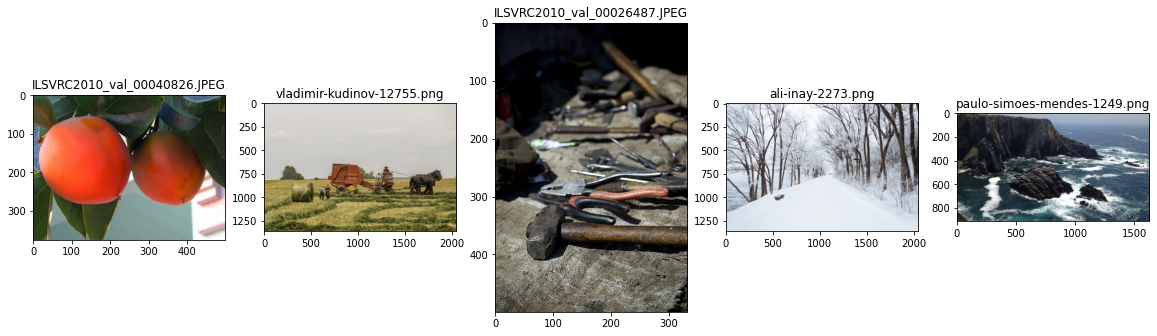

In [7]:
# Displaying of sample training dataset images
import os 
import random       
train_dir = input ("Enter the path of training directory :")                                                               
plt.figure(figsize=(20,20))
for i in range(5):
    file = random.choice(os.listdir(train_dir))
    image_path= os.path.join(train_dir, file)
    img=mpimg.imread(image_path)
    ax=plt.subplot(1,5,i+1)
    ax.title.set_text(file)
    plt.imshow(img)

In [8]:
# Loading of the images from the folder into training dataset
from PIL import Image
# Croping the image to match the input size of the encoder and converting to a tensor
TRAIN_TRANSFORMS_256 = transforms.Compose([transforms.RandomResizedCrop(256),
                                                   transforms.ToTensor()])
#function to load a image from a specified path
def load_image(path):
    return Image.open(path).convert("RGB")

#function to create a dataset
def create_dataset(img_folder):
    count = 0
    img_data_array=[]
    for file in os.listdir(img_folder):
        count = count+ 1
        image_path= os.path.join(img_folder,  file)
        image= load_image(image_path)
        image_tensor = TRAIN_TRANSFORMS_256(image).to(device)
        img_data_array.append(image_tensor)
    return img_data_array


train_img_data =create_dataset(train_dir)
train_loader = torch.utils.data.DataLoader(train_img_data, batch_size=100, shuffle=True)
print('Training dataset loading completed')

Training dataset loading completed


**Loss Functions**

Loss function1 : This is the square root of the mean square error between the input image and the reconstructed image. This is used while pretraining the model without the importance map.

Loss Function2 : This is the sum of Rate Loss (square root of Mean square error) and 0.001*distortion Loss (sum of each value of importance map). This function is used during the final end to end training of the model along with the importance map.


In [9]:
# Loss function1
def loss_fn(input,output):
  rate_loss = nn.MSELoss()
  loss = torch.sqrt((rate_loss(input,output)))
  return loss

In [20]:
# Loss function2
def loss_fn2(input,output):
  rate_loss = nn.MSELoss()
  dist_loss = torch.sum(imp_map)
  if(dist_loss > 5000):
    dist_loss = dist_loss -5000
  else:
    dist_loss = 0
  loss = (rate_loss(input,output)) + 0.001*dist_loss
  return loss

**Full Network**

This class uses the individual networks defined above to form a complete model. It contains an encoder, importance map generator, quantizer, binarizer, mask generator and decoder. All these models are made into a single model to faciliate the end-to-end learning of the model.

In [11]:
import argparse
import torch
import torch.nn
from torch.utils.data import DataLoader
import os
from torchvision.utils import save_image

class full_layers(nn.Module):
  def __init__(self,imp_map_present = False):
        super(full_layers, self).__init__()
        self.encoder = Encoder()
        self.encoder_rest = Encoder_full()
        self.imp_map_gen = Encoder_full(True)
        self.decoder = Decoder()     
  def forward(self,x,imp_map_present = False):
    #print(x.shape)
    inter_result = self.encoder(x)
    #print(quantized_op)
    op1 = binary_value(self.encoder_rest(inter_result)).to(device)
    #print(op1.shape,op2.shape)
    if(imp_map_present == True):
      importance_map = self.imp_map_gen(inter_result, True)
      quantized_op = quantize_values(importance_map).to(device)
      masked_op = generateMask(quantized_op).to(device)
      op2 = masked_op.to(device)
      y = (op1*op2).to(device)
      return self.decoder(y), importance_map
    else:
      y = op1.to(device)
    return self.decoder(y)
# full network without im
fullnet = full_layers(False).to(device)
print(fullnet.parameters)

<bound method Module.parameters of full_layers(
  (encoder): Encoder(
    (conv1): Conv2d(3, 128, kernel_size=(8, 8), stride=(4, 4), padding=(2, 2))
    (res_block1): ResBlock(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (conv2): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (res_block2): ResBlock(
      (conv1): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (res_block3): ResBlock(
      (conv1): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
  )
  (encoder_rest): Encoder_full(
    (sig): Sigmoid()
    (conv3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (sig1): Sigmoid()
    (conv4

**Pretraining**

The importance map generator is removed from the model and the system is pretrained using the training data set. ADAM solver is used and the learning rates are 0.0001, 0.00001 and 0.00001. Loss function1 is used and the model is trained until the loss function almost remains constant. The loss is printed for every 100 images.

In [12]:
fullnet.train() # training the network
return_imp_map = False # importance map is not considered during pretraining
# importance map parameters are set to false
for p in fullnet.imp_map_gen.parameters():
  p.requires_grad_ = False
optimizer = torch.optim.Adam(fullnet.parameters(), lr=0.0001)
running_loss = 0.0
trial = [[[]]]
print('Training the model without importance map - number of epochs 12')
for epoch in range(12):
  for i,data in enumerate(train_img_data, 0):
    inputs = data.unsqueeze(0).to(device)
    inputs = Variable(inputs)
    trial = inputs
    optimizer.zero_grad()
    for p in fullnet.imp_map_gen.parameters():
      p.requires_grad = False
    output = fullnet(inputs,False)
    output = output
    loss = loss_fn(output, inputs)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
    if i%100 == 99:
      print('[%5d to %5d image samples in %1d epoch] loss: %.5f'% (i-99,i+1,epoch+1,running_loss/100))
      if(running_loss/100 < 0.06):
        optimizer = torch.optim.Adam(fullnet.parameters(), lr=0.00001)
      if(running_loss/100 < 0.05):
        optimizer = torch.optim.Adam(fullnet.parameters(), lr=0.000001)
      if(running_loss/100< 0.008):
        break
      running_loss = 0.0
PATH = './cifar_net.pth'
# parameters are saved for usage during full network training
torch.save(fullnet.state_dict(), PATH)


Training the model without importance map - number of epochs 12
[    0 to   100 image samples in 1 epoch] loss: 0.24206
[  100 to   200 image samples in 1 epoch] loss: 0.16250
[  200 to   300 image samples in 1 epoch] loss: 0.15829
[  300 to   400 image samples in 1 epoch] loss: 0.12879
[  400 to   500 image samples in 1 epoch] loss: 0.11215
[  500 to   600 image samples in 1 epoch] loss: 0.11479
[  600 to   700 image samples in 1 epoch] loss: 0.11416
[  700 to   800 image samples in 1 epoch] loss: 0.11494
[  800 to   900 image samples in 1 epoch] loss: 0.10256
[  900 to  1000 image samples in 1 epoch] loss: 0.12196
[ 1000 to  1100 image samples in 1 epoch] loss: 0.11740
[ 1100 to  1200 image samples in 1 epoch] loss: 0.11053
[ 1200 to  1300 image samples in 1 epoch] loss: 0.10133
[ 1300 to  1400 image samples in 1 epoch] loss: 0.09595
[ 1400 to  1500 image samples in 1 epoch] loss: 0.10434
[ 1500 to  1600 image samples in 1 epoch] loss: 0.09692
[ 1600 to  1700 image samples in 1 epoch

**Training**

The importance map generator is added into the model and the system is pretrained using the training data set. ADAM solver is used and the learning rates are 0.0001, 0.00001 and 0.00001. Foss function1 is used and the model is trained until the loss function almost remains constant.

In [13]:
fullnet1 = full_layers(True).to(device)
fullnet1.load_state_dict(torch.load(PATH))
fullnet1.train() # training the network
running_loss = 0.0
for p in fullnet1.imp_map_gen.parameters():
  p.requires_grad = False
for q in fullnet1.encoder.parameters():
  q.requires_grad = False
trial = [[[]]]
optimizer = torch.optim.Adam(fullnet1.parameters(), lr=0.0001)
print('Training with learning rate 10^-4')
for epoch in range(3):
  for i,data in enumerate(train_img_data, 0):
    inputs = data.unsqueeze(0).to(device)
    inputs = Variable(inputs)
    trial = inputs
    optimizer.zero_grad()
    for p in fullnet1.imp_map_gen.parameters():
     p.requires_grad = False
    for q in fullnet1.encoder.parameters():
     q.requires_grad = False
    output = fullnet1(inputs,True)
    imp_map = output[1] 
    output = output[0]
    loss = loss_fn2(output, inputs)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
    if i%100 == 99:
      print('[%5d to %5d image sample in %5d epoch] loss: %.5f'% (i-99,i+1,epoch+1,running_loss/100))
      running_loss = 0.0
optimizer = torch.optim.Adam(fullnet1.parameters(), lr=0.00001)
print('Training with learning rate 10^-5')
for epoch in range(3):
  for i,data in enumerate(train_img_data, 0):
    inputs = data.unsqueeze(0).to(device)
    inputs = Variable(inputs)
    trial = inputs
    optimizer.zero_grad()
    for p in fullnet1.imp_map_gen.parameters():
     p.requires_grad = False
    for q in fullnet1.encoder.parameters():
     q.requires_grad = False
    output = fullnet1(inputs,True)
    imp_map = output[1] 
    output = output[0]
    loss = loss_fn2(output, inputs)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
    if i%100 == 99:
      print('[%5d to %5d image sample in %5d epoch] loss: %.5f'% (i-99,i+1,epoch+1,running_loss/100))
      running_loss = 0.0
optimizer = torch.optim.Adam(fullnet1.parameters(), lr=0.000001)
print('Training with learning rate 10^-6')
for epoch in range(3):
  for i,data in enumerate(train_img_data, 0):
    inputs = data.unsqueeze(0).to(device)
    inputs = Variable(inputs)
    optimizer.zero_grad()
    trial = inputs
    for p in fullnet1.imp_map_gen.parameters():
     p.requires_grad = False
    for q in fullnet1.encoder.parameters():
     q.requires_grad = False
    output = fullnet1(inputs,True)
    imp_map = output[1] 
    output = output[0]
    loss = loss_fn2(output, inputs)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
    if i%100 == 99:
      print('[%5d to %5d image sample in %5d epoch] loss: %.5f'% (i-99,i+1,epoch+1,running_loss/100))
      running_loss = 0.0

Training with learning rate 10^-4
[    0 to   100 image sample in     1 epoch] loss: 0.07639
[  100 to   200 image sample in     1 epoch] loss: 0.06889
[  200 to   300 image sample in     1 epoch] loss: 0.06680
[  300 to   400 image sample in     1 epoch] loss: 0.05820
[  400 to   500 image sample in     1 epoch] loss: 0.05264
[  500 to   600 image sample in     1 epoch] loss: 0.06085
[  600 to   700 image sample in     1 epoch] loss: 0.06133
[  700 to   800 image sample in     1 epoch] loss: 0.05917
[  800 to   900 image sample in     1 epoch] loss: 0.05832
[  900 to  1000 image sample in     1 epoch] loss: 0.06866
[ 1000 to  1100 image sample in     1 epoch] loss: 0.05743
[ 1100 to  1200 image sample in     1 epoch] loss: 0.05958
[ 1200 to  1300 image sample in     1 epoch] loss: 0.05419
[ 1300 to  1400 image sample in     1 epoch] loss: 0.04994
[ 1400 to  1500 image sample in     1 epoch] loss: 0.05843
[ 1500 to  1600 image sample in     1 epoch] loss: 0.05654
[ 1600 to  1700 image 

**Testing**

A subset of the imagenet dataset is used as the test samples. The program displays the input image, importance map and the reconstructed image of the test images.

Enter the path of test directory :/content/drive/MyDrive/Colab Notebooks//test


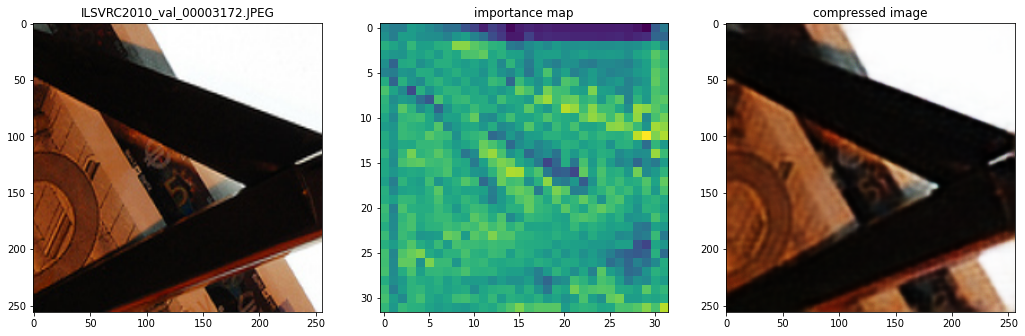

In [17]:
torch.save(fullnet1.state_dict(), PATH)
import os 
import random     
from PIL import Image
fullnet2 = full_layers(True).to(device)
fullnet2.load_state_dict(torch.load(PATH))
test_dir = input ("Enter the path of test directory :")          
TRAIN_TRANSFORMS_reverse = transforms.Compose([transforms.ToPILImage()])
plt.figure(figsize=(30,30))
fullnet1.eval()
for i in range(1):
  file = random.choice(os.listdir(test_dir))
  image_path= os.path.join(test_dir, file)
  image= load_image(image_path)
  image_tensor = TRAIN_TRANSFORMS_256(image)
  inputs = image_tensor.unsqueeze(0)
  inputs = Variable(inputs.to(device))
  output = fullnet1(inputs,True)[0]
  map = fullnet1(inputs,True)[1]
  ax=plt.subplot(1,5,i+1)
  ax.title.set_text(file)
  plt.imshow(TRAIN_TRANSFORMS_reverse(image_tensor.squeeze_(0)))
  ax=plt.subplot(1,5,i+2)
  ax.title.set_text("importance map")
  plt.imshow(TRAIN_TRANSFORMS_reverse(map.squeeze_(0)))
  ax=plt.subplot(1,5,i+3)
  ax.title.set_text("compressed image")
  plt.imshow(TRAIN_TRANSFORMS_reverse(output.squeeze_(0)))
  output_img = TRAIN_TRANSFORMS_reverse(output.squeeze_(0))
  input_img = TRAIN_TRANSFORMS_reverse(image_tensor.squeeze_(0))

**Evaluation of the result**

The peak signal to noise ratio (PSNR) and structural similarity index measure (SSIM) values of the test images are evaluated to know the quality of the reconstruction

In [18]:
#ssim value evaluation
ssim =tf.image.ssim(inputs.detach().cpu(),output.squeeze_(0).detach().cpu(),max_val=1, filter_size=3)
print("SSIM value: %.5f"%(ssim))

SSIM value: 0.93026


In [19]:
#psnr value evaluation
from math import log10, sqrt
x = map.squeeze_(0)[0].cpu()
y = map.squeeze_(0)[1].cpu()
loss = loss_fn(inputs.squeeze_(0),output.squeeze_(0))
psnr_loss = 20*log10(1/0.05)
print("Square root of MSE loss: %.5f"%(loss))
print("PSNR value in dB: %.5f "%(psnr_loss))

Square root of MSE loss: 0.03191
PSNR value in dB: 26.02060 
